# Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Loading the data

In [3]:
#sample_submission = pd.read_csv("C:/Users/odeli/Desktop/DataCamp/sample_submission.csv")
#test = pd.read_csv("C:/Users/odeli/Desktop/DataCamp/test.csv")
#specs = pd.read_csv("C:/Users/odeli/Desktop/DataCamp/specs.csv")
#train_labels = pd.read_csv("C:/Users/odeli/Desktop/DataCamp/train_labels.csv")
#train = pd.read_csv("C:/Users/odeli/Desktop/DataCamp/train.csv")

In [13]:
print('Shapes:\n - train: ', np.shape(train), '\n - train_labels: ',np.shape(train_labels), '\n - test: ',np.shape(test), '\n - specs: ',np.shape(specs), '\n - sample_submission: ',np.shape(sample_submission))

Shapes:
 - train:  (11341042, 11) 
 - train_labels:  (17690, 7) 
 - test:  (1156414, 11) 
 - specs:  (386, 3) 
 - sample_submission:  (1000, 2)


# Objective

PBS KIDS Measure Up! = app to test children.
Five assesments with several levels :
* Bird Measurer 
* Cart Balancer 
* Cauldron Filler 
* Chest Sorter
* Mushroom Sorter

Intent of the competition: use the gameplay data to **forecast how many attempts a child will take to pass a given assessment** (an incorrect answer is counted as an attempt)

# Understanding the data

### The target Variable

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

* 3: the assessment was solved on the first attempt
* 2: the assessment was solved on the second attempt
* 1: the assessment was solved after 3 or more attempts
* 0: the assessment was never solved

multi-class classification

In [16]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [54]:
train_labels.groupby('accuracy_group').count()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy
accuracy_group,,,,,,
0,4229,4229,4229,4229,4229,4229
1,2411,2411,2411,2411,2411,2411
2,2205,2205,2205,2205,2205,2205
3,8845,8845,8845,8845,8845,8845


!!!! Unbalanced-class !!!! : weights ?? check if it's the same in the "real" train after cleanning

train_labels file shows us the "shape" of the "real" test file. So we have to "build" some variables from the train file to fit this "shape".

### Train and test

In [14]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [59]:
train.iloc[5]['event_data']

'{"coordinates":{"x":583,"y":605,"stage_width":1015,"stage_height":762},"event_count":4,"game_time":9991,"event_code":4070}'

* **event_id** : identifier for the event type ( = event_id in specs)


* **game_session** : identifier grouping events within a single game or video play session


* **timestamp** : Client-generated datetime


* **event_data** : Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.


* **installation_id** : identifier grouping game sessions within a single installed application instance.


* **event_count** : Incremental counter of events within a game session (offset at 1). Extracted from event_data.


* **event_code** : Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.


* **game_time** : Time in milliseconds since the start of the game session. Extracted from event_data.


* **title** : Title of the game or video.


* **type** : Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.


* **world** : The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

In [20]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


### Specs

In [19]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


This file gives the specification of the various event types.

* **event_id** : Global unique identifier for the event type. Joins to event_id column in events table.


* **info** : Description of the event.


* **args** : JSON formatted string of event arguments. Each argument contains:

    * **name** : Argument name.
    * **type** : Type of the argument (string, int, number, object, array).
    * **info** : Description of the argument.


In [34]:
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


# Mini-data to keep my computer from dying

### Reminder: take care of the class balancing !!

In [105]:
from sklearn.model_selection import train_test_split

It's just to check that the function is working. We have to clean the train before spliting it because we need the "accuracy_group" variable

trash = the rest of the "big" dataset

In [119]:
trash, mini_train = train_test_split(train_labels, test_size=0.1, random_state=42, stratify = train_labels['accuracy_group'])

In [120]:
np.shape(train_labels)  ,np.shape(mini_train)

((17690, 7), (1769, 7))

# Focus on the train-test: Cleaning + Vizualisation


In [63]:
# Format and make date / hour features
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['date'] = train['timestamp'].dt.date
train['hour'] = train['timestamp'].dt.hour
train['weekday_name'] = train['timestamp'].dt.weekday_name
# Same for test
test['timestamp'] = pd.to_datetime(test['timestamp'])
test['date'] = test['timestamp'].dt.date
test['hour'] = test['timestamp'].dt.hour
test['weekday_name'] = test['timestamp'].dt.weekday_name

In [71]:
train['timestamp'].head()

0   2019-09-06 17:53:46.937000+00:00
1   2019-09-06 17:54:17.519000+00:00
2   2019-09-06 17:54:56.302000+00:00
3   2019-09-06 17:54:56.387000+00:00
4   2019-09-06 17:55:03.253000+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

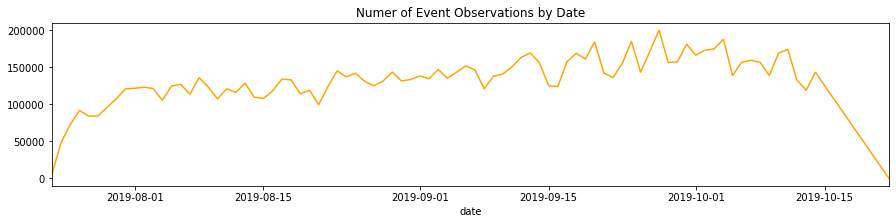

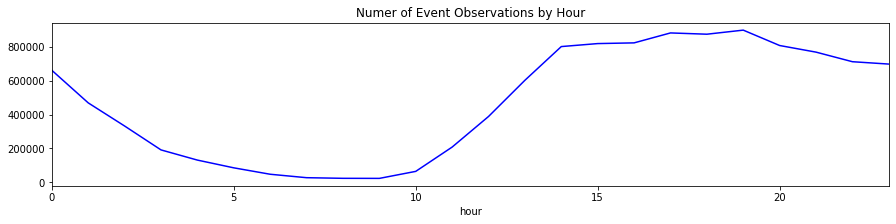

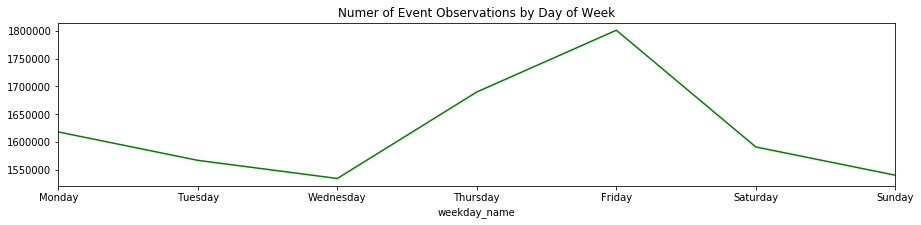

In [73]:
train.groupby('date')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Date',
         color= 'orange')
plt.show()
train.groupby('hour')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Hour',
         color= 'blue')
plt.show()
train.groupby('weekday_name')['event_id'] \
    .agg('count').T[['Monday','Tuesday','Wednesday',
                     'Thursday','Friday','Saturday',
                     'Sunday']].T.plot(figsize=(15, 3),
                                       title='Numer of Event Observations by Day of Week',
                                       color= 'green')
plt.show()

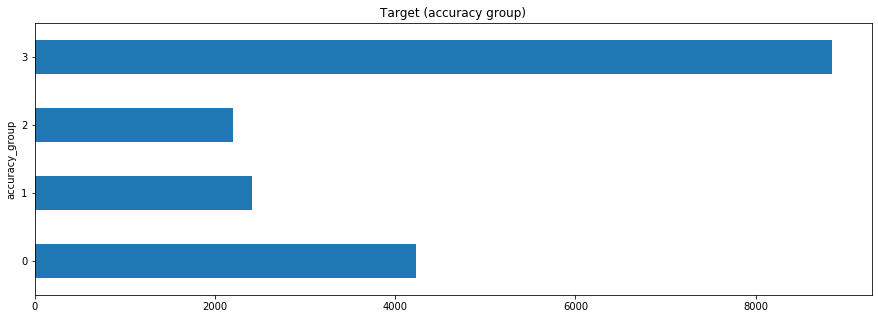

In [53]:
train_labels.groupby('accuracy_group')['game_session'] \
            .count() \
            .plot(kind='barh', figsize=(15, 5), title='Target (accuracy group)')

(array([4357.,  491.,  842.,  950.,    0., 2205.,    0.,    0.,    0.,
        8845.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

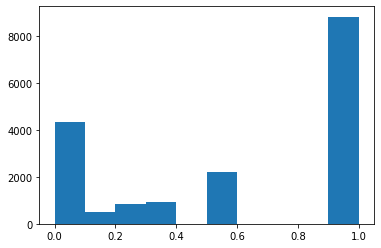

In [39]:
plt.hist(train_labels['accuracy'])

# ToDo / Questions

Cleanning the train.

exctracting 2 information : num_correct, num_incorrect

build 4 informations: num_correct, num_incorrect, accuray, accuracy_group

Other variables useful ??

## Making labels

In [42]:
def make_labels(data):
    """
     1. Ne garder que les lignes où l'event_code vaut 4100 ou 4110: correspond aux event finaux d'une game_session
         donc contennant l'info de succés ou d'echecs
     2. groupby par game_session
     3. Au sein de chaque game_session compter le nombre de succés et d'echec
     4. Calcul l'accuracy_score = nb_succes / nb_tentatives ou nb_tentatives = nb_succes + nb_echecs
     5. Construction de la variable accuracy: repartition dans les classes.
    """
    
    data_labelled = data[(data['event_code'] == 4100) | (data['event_code'] == 4110)]
    
    
    return data_labelled

In [43]:
np.shape(make_labels(mini))

(10271, 11)

In [31]:
mini = train[0:50000]
np.shape(train), np.shape(mini)

((11341042, 11), (50000, 11))

In [68]:
test = "hello je test un truc"
type(test)


str

In [69]:
pd.Series(test)
type(test)

str

In [65]:
pd.Series(test).str.contains('t')

0    True
dtype: bool

In [60]:
nb_correct = tmp['event_data'].count(pd.series.str.contains('true'))

AttributeError: module 'pandas' has no attribute 'series'

In [44]:
tmp = mini[(mini['event_code'] == 4100) | (mini['event_code'] == 4110)]

In [45]:
np.shape(tmp)

(10271, 11)

In [56]:
test = tmp.groupby('game_session') #.count(tmp['event_data'].str.contains('true'))
np.shape(test)
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,4110,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,4110,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,4110,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,4110,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,4110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK
5,1325467d,0848ef14a8dc6892,2019-09-06T17:55:06.279Z,"{""coordinates"":{""x"":583,""y"":605,""stage_width"":...",0001e90f,4,4110,9991,Sandcastle Builder (Activity),Activity,MAGMAPEAK
6,1325467d,0848ef14a8dc6892,2019-09-06T17:55:06.913Z,"{""coordinates"":{""x"":601,""y"":570,""stage_width"":...",0001e90f,5,4110,10622,Sandcastle Builder (Activity),Activity,MAGMAPEAK
269,77261ab5,a1ec58f109218255,2019-09-06T17:58:28.042Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,4110,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
270,b2dba42b,a1ec58f109218255,2019-09-06T17:58:28.134Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,4110,44,Sandcastle Builder (Activity),Activity,MAGMAPEAK
271,1325467d,a1ec58f109218255,2019-09-06T17:58:31.759Z,"{""coordinates"":{""x"":850,""y"":214,""stage_width"":...",0001e90f,3,4110,3713,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [55]:
np.shape(pd.unique(tmp['game_session']))

(286,)

In [30]:
mini['title']

0             Welcome to Lost Lagoon!
1                Magma Peak - Level 1
2       Sandcastle Builder (Activity)
3       Sandcastle Builder (Activity)
4       Sandcastle Builder (Activity)
5       Sandcastle Builder (Activity)
6       Sandcastle Builder (Activity)
7       Sandcastle Builder (Activity)
8       Sandcastle Builder (Activity)
9       Sandcastle Builder (Activity)
10      Sandcastle Builder (Activity)
11      Sandcastle Builder (Activity)
12      Sandcastle Builder (Activity)
13      Sandcastle Builder (Activity)
14      Sandcastle Builder (Activity)
15      Sandcastle Builder (Activity)
16      Sandcastle Builder (Activity)
17      Sandcastle Builder (Activity)
18      Sandcastle Builder (Activity)
19      Sandcastle Builder (Activity)
20      Sandcastle Builder (Activity)
21      Sandcastle Builder (Activity)
22      Sandcastle Builder (Activity)
23      Sandcastle Builder (Activity)
24      Sandcastle Builder (Activity)
25      Sandcastle Builder (Activity)
26      Sand

In [13]:
np.shape(filter(mini['event_code'] == 4110, mini))

()

In [14]:
test = [mini for mini['event_code'] in (4100,4110)]

C:\Users\odeli\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
